In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

import os
import json

%matplotlib inline


main_path = "../../"

video_file = "IMG_0606.MOV"
matrix_path = os.path.join(main_path, "homography/matrixes/thai_hom_matrix_last.npy")
homography_matrix = np.load(matrix_path)
test_video = os.path.join(main_path, "datasets/thai/Videos/", video_file)
result_folder = os.path.join(main_path, "results/tracks/")

In [2]:
def get_tracking(tracking_path):
    with open(tracking_path) as f:
        return json.load(f)

# Omografia
def remap_point(point, h_matrix):
    p_h = np.array([[point]], dtype='float32')
    transformed_point_array = cv2.perspectiveTransform(p_h, h_matrix)
    return tuple(transformed_point_array[0][0])

# Velocità del veiclo tra frame iniziale e finale
def calculate_speed(positions, frame_rate, cm_per_pixel = (300 / 69)):
    # Calcola solo un certo range di punti [200, 800], così siamo più precisi (nello spazio omografico corrisponde a circa 24m)
    filtered_positions = {k: v for k, v in positions.items() if v[1] >= 200 and v[1] <= 800}
    if not len(filtered_positions):
        return None
    
    sorted_keys = sorted(filtered_positions.keys())
    f_index = sorted_keys[-1]
    i_index = sorted_keys[0]
    frames_difference = f_index - i_index + 1
    if frames_difference < 60:      # Rimuovi casi di overlap istantaneo
        return None
    initial_point = remap_point(filtered_positions[i_index], homography_matrix)
    final_point = remap_point(filtered_positions[f_index], homography_matrix)

    # Calcola la distanza tra frame in pixel
    distance = np.sqrt((final_point[0] - initial_point[0]) ** 2 + (final_point[1] - initial_point[1]) ** 2)
    # Converti la distanza in metri
    distance_meters = (distance * cm_per_pixel) / 100
    # Tempo in secondi
    secs = frames_difference / frame_rate
    # Calcola velocità in km/h
    speed = (3.6 * distance_meters) / secs
    # Tieni conto delle prime due cifre decimali
    return round(speed, 2)

def get_vehicles_dictionary(history):
    all_vehicles = {}
    for frame, objects in history.items():

        # Per ogni veicolo presente nel frame aggiungi la posizione (centrata) e il frame al database dei veicoli
        for vehicle_id, vehicle in objects.items():
            x1, y1, x2, y2 = vehicle['bbox']
            center_x = (x1 + x2) // 2
            center_y = (y1 + y2) // 2
            #obj_center = remap_point((center_x, center_y), homography_matrix)
            if vehicle_id not in all_vehicles:
                all_vehicles[vehicle_id] = {int(frame): (center_x, center_y)}
            else:
                all_vehicles[vehicle_id][int(frame)] = (center_x, center_y)
            # aggiungi ultimo bndbox
            all_vehicles[vehicle_id]["bbox"] = [x1, y1, x2, y2]
    return all_vehicles


In [13]:
def draw_track_in_frame(all_vehicles, frame_rate, vehicle_id):
    vehicle_with_bb = all_vehicles[vehicle_id].copy()

    # Prendi i frame estremi di questo id
    x1, y1, x2, y2 = vehicle_with_bb["bbox"]
    del vehicle_with_bb["bbox"]
    vehicle = vehicle_with_bb
    
    speed_estimation = calculate_speed(vehicle, frame_rate)

    if speed_estimation is None:
        out_str = f"ID: {vehicle_id}"
        print("Troppi pochi frame per calcolare la velocità di id:", vehicle_id)
    else:
        out_str = f"Speed: {speed_estimation} km/h ID: {vehicle_id}"

    # L'ultimo frame
    sorted_keys = sorted(vehicle.keys())
    f_index = sorted_keys[-1]

    print("Veicolo id:", vehicle_id, "\nVado all'ultimo frame:", f_index)

    # Recupera ultimo frame di apparizione dal video
    cap = cv2.VideoCapture(test_video)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_number = 1
    while cap.isOpened() and frame_number <= total_frames:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_number != f_index:
            frame_number += 1
            continue
        break
    cap.release()

    print("Frame", frame_number, "per l'id", vehicle_id)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    for frame_n, position in vehicle.items():
        px, py = position
        cv2.circle(frame_rgb, (int(px), int(py)), radius=4, color=(0, 128, 255), thickness=-1)

    # Aggiungi bounding box
    print("Ultimo bounding box", (int(x1), int(y1)), (int(x2), int(y2)))
    c = (0, 200, 0)
    cv2.line(frame_rgb, (0, 200), (1920, 200), (255, 0, 0), 2)
    cv2.line(frame_rgb, (0, 800), (1920, 800), (255, 0, 0), 2)
    cv2.rectangle(frame_rgb, (int(x1), int(y1)), (int(x2), int(y2)), c, 4)
    cv2.putText(frame_rgb, out_str, (int(x1) - 300, int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, c, 4)

    plt.figure(figsize=(16, 9))
    plt.imshow(frame_rgb)
    plt.axis('off')
    plt.show()


Processing IMG_0606
Ho contato 2 veicoli
Veicolo id: 2.0 
Vado all'ultimo frame: 335
Frame 335 per l'id 2.0
Ultimo bounding box (1024, 189) (1066, 220)


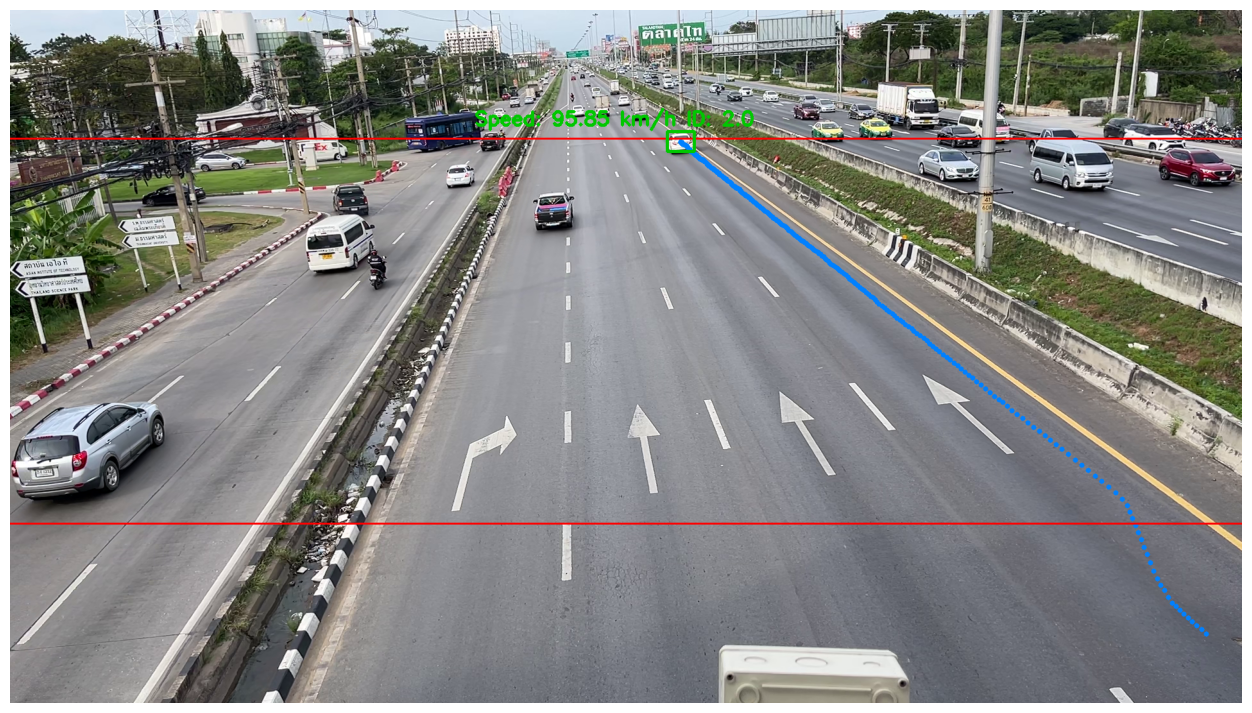

In [14]:
# MAIN
frame_rate = 120

video_name = os.path.splitext(os.path.basename(video_file))[0]

print(f"Processing {video_name}")

history = get_tracking(os.path.join(result_folder, video_name + ".json"))

all_vehicles = get_vehicles_dictionary(history)

print("Ho contato", len(all_vehicles), "veicoli")

vehicle_id = random.choice(list(all_vehicles.keys()))
draw_track_in_frame(all_vehicles, frame_rate, vehicle_id)